<a href="https://colab.research.google.com/github/stavco9/nlp-final-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/stavco9/nlp-final-project.git

Cloning into 'nlp-final-project'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 303 (delta 8), reused 11 (delta 4), pack-reused 286 (from 1)
Receiving objects: 100% (303/303), 9.20 MiB | 8.43 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [2]:
%cd /content/nlp-final-project/

/content/nlp-final-project


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.5/99.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadat

In [4]:
import os
import json
import pandas as pd
import numpy as np
import requests

In [5]:
# Mount Google Drive
from google.colab import drive, files
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/IDC_MSc/Year1/NLP/Final-Project/data" ./data

Mounted at /content/drive


In [ ]:
# Please set a valid Google API
# Please download the 'data' folder from https://drive.google.com/drive/folders/1D-OHX0LUNA5Y-0h8UXwqa4H_yETZN_t_ to your project root directory

GOOGLE_API_KEY = '**********************'

In [ ]:
##
## Dataset preperation part
##

In [ ]:
from modules.dataset.transcript_dataset import TranscriptDataset

dataset_builder = TranscriptDataset(api_key=GOOGLE_API_KEY)

# dataset_folder => The folder to load / save the datasets file from. If not exists it will create it automatically
# videos_count => Total number of videos to include in the dataset. If there are already saved videos in the "data" folder,
# it will fill the remaining videos count (For example if the parameter: videos_count is 4000 and there are already 1500 videos
# in the folder, it will fetch 2500 videos). Default is 100
# country_code => 2 digits ISO Code of the country you want to fetch videos from (If not set, the default is United States 'us')
# Relevant codes for countries with a majority of English based videos => 'ca' Canada, 'uk' United Kingdom, 'au' Australia, 'in' India
#  'nz' New Zealand, 'za' South Africa
# language => 2 digits ISO Code of the video's language you want to use (If not set, the default is English 'en')
dataset_builder.build_dataset(dataset_folder='data/dataset', videos_count=5000, country_code='uk')

# dataset_folder => The folder to load / save the datasets file from. If not exists it will create it automatically
# comments_count => The amount of comments to fetch for each video. Default is 100
dataset_builder.build_comments(dataset_folder='data', comments_count=200)

There are currnet 5000 videos in 10 files
There are already at least 5000. No need to do anything


In [ ]:
##
## Sentiment analysis part
##

In [6]:
from modules.sentiment_analysis.comments_sentiment_analysis import multi_sentiment_score
from modules.sentiment_analysis.video_info import Video_info, datumToObj, save_to_json, save_to_pickle
from modules.sentiment_analysis.GPT_comment_controversy import init_openai, get_disagreement_rating
from modules.sentiment_analysis.scoring_video import adjust_disagreement_rating

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# put all the json into pickle
datasets = [f'data/dataset/dataset_{i}.json' for i in range(10)]
to_print = True #input("Do you want to show prints? (y/n): ") != 'n'
basic_inf_vids = datumToObj(datasets, 'data/sentiment/videos_sample.pkl', to_print)
number_of_vids = len(basic_inf_vids)

save_to_json(basic_inf_vids, 'data/sentiment/vids_no_sentiment.json')
sentiment_model = multi_sentiment_score
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
count = 0
for vid in basic_inf_vids:
    print_text = "\r"
    if to_print:
        count += 1
        print_text += f"Processing video {count}/{number_of_vids}"
    vid.add_comments_scores(sentiment_model, model_name)
    if to_print:
        print_text += f" - Disagreement rating: {vid.comments_controversy_classical}"
    if to_print:
        print(print_text)

save_to_json(basic_inf_vids, 'data/sentiment/vids_classical_sentiment.json')
basic_inf_vids = adjust_disagreement_rating(basic_inf_vids)
save_to_json(basic_inf_vids, 'data/sentiment/videos_classical_sentiment_adjusted.json')
'''

#load vids from videos_classical_sentiment_adjusted.json and adjust basic_inf_vids with its values
with open('data/data/videos_classical_sentiment_adjusted.json') as json_file:
    json_obj = json.load(json_file)
for i, video_obj in enumerate(json_obj):
    basic_inf_vids[i].comments_controversy_classical = float(video_obj['comments_controversy_classical'])
'''


to_continue = True #input("Do you want to continue with GPT? (y/n): ")
if not to_continue:
  print("Done")
else:
  count = 0
  client = init_openai()
  sentiment_model=get_disagreement_rating
  model_name="GPT"
  for vid in basic_inf_vids:
      print_text = "\r"
      if to_print:
          count += 1
          print_text += f"Processing video {count}/{number_of_vids}"
      vid.add_comments_scores(sentiment_model, model_name, client)
      if to_print:
          print_text += f" - Disagreement rating: {vid.comments_controversy_GPT}"
      if to_print:
          print(print_text)
  save_to_json(basic_inf_vids, 'data/data/vids_GPT_sentiment.json')

In [ ]:
##
## Training part
##

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import random
import numpy as np
import json
import os
from modules.azsclm.azsclm import AZSC_LanguageModel
from modules.azsclm.board import Board
from transformers import AutoTokenizer

In [8]:
class Config_Model:
    def __init__(self, num_epochs, train_data, valid_data, test_data, model, optimizer, threshold_percentage, criterion, device):
        self.num_epochs = num_epochs
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.threshold_percentage = threshold_percentage


class Model:
    def __init__(self, config, data_name = 'GPT'):
        self.num_epochs = config.num_epochs
        self.train_data = config.train_data
        self.valid_data = config.valid_data
        self.test_data = config.test_data
        self.pred_score = []
        self.true_score = []
        self.device = config.device
        self.model = config.model
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.data_name = 'comments_controversy_' + data_name
        self.max_available = 1
        self.min_available = -1
        self.board = Board()

    def calculate_accuracy(self, min_item, max_item, pred, true):
        pred = max(pred, self.min_available)
        pred = min(pred, self.max_available)
        true = max(true, self.min_available)
        true = min(true, self.max_available)

        acc = 1 - (abs(pred - true) / abs(max_item - min_item))
        return float(acc)

    def train(self):
        size = len(self.train_data.dataset)
        num_train_batches = len(self.train_data)
        num_valid_batches = len(self.valid_data)
        self.model.train()
        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            epoch_loss = 0

            for batch_idx, (src, trg) in enumerate(self.train_data):
                src, trg = src.to(self.device), trg.to(self.device)
                output = self.model(src)

                self.optimizer.zero_grad()
                loss = self.criterion(output, trg)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.5)
                train_loss = loss.item()
                self.optimizer.step()
                epoch_loss += train_loss

            self.board.info_handler(loss=train_loss, batch=batch_idx, size=size, epoch_loss=epoch_loss, name='(training) ' + self.data_name)

            print("Evaluating with validation set")
            self.model.eval()
            running_valid_loss = 0
            total_acc = 0

            list_targets = [item[1].to('cuda') for item in self.valid_data]
            list_targets = torch.stack(list_targets, dim=1).to('cuda')
            max_item = min(torch.max(list_targets).item(), self.max_available)
            min_item = max(torch.min(list_targets).item(), self.min_available)

            # Disable gradient computation and reduce memory consumption.
            with torch.no_grad():
                for batch_idx, (src, trg) in enumerate(self.valid_data):
                    src, trg = src.to(self.device), trg.to(self.device)
                    output = self.model(src)
                    loss = self.criterion(output, trg)
                    valid_loss = loss.item()
                    running_valid_loss += valid_loss
                    total_acc += self.calculate_accuracy(max_item, min_item, output, trg)
                    avg_acc = total_acc / (batch_idx + 1)

                    if batch_idx % 20 == 0:
                      print(f"Accuracy: {avg_acc}")

            avg_train_loss = epoch_loss / num_train_batches
            avg_valid_loss = running_valid_loss / num_valid_batches
            print(f"Average train loss: {avg_train_loss}, avarage valid loss: {avg_valid_loss}")
            avg_acc = total_acc / num_valid_batches
            print(f"Average accuracy rate: {avg_acc}")

        batch = next(iter(self.train_data))
        src = batch[0].to(self.device)
        self.board.add_graph(self.model, src)

    def test(self):
        size = len(self.test_data.dataset)
        num_batches = len(self.test_data)
        self.model.eval()
        epoch_loss = 0.0
        sections_losses = {}
        total_acc = 0

        list_targets = [item[1].to('cuda') for item in self.test_data]
        list_targets = torch.stack(list_targets, dim=1).to('cuda')
        max_item = min(torch.max(list_targets).item(), self.max_available)
        min_item = max(torch.min(list_targets).item(), self.min_available)
        with torch.no_grad():
            for batch_idx, (src, trg) in enumerate(self.test_data):
                src, trg = src.to(self.device), trg.to(self.device)
                pred = self.model(src)
                pred = pred.to(self.device)
                loss = self.criterion(pred, trg)
                #for section_name, section_loss in loss.last_losses.items():
                #    if section_name not in sections_losses:
                #        sections_losses[section_name] = torch.Tensor([0]).to(self.device)
                #    sections_losses[section_name] += section_loss
                #for section_name in sections_losses.keys():
                #    sections_losses[section_name] /= size
                epoch_loss = self.board.info_handler(loss=loss.item(), batch=batch_idx, size=size, epoch_loss=epoch_loss, name = '(test) ' + self.data_name)
                avg_loss = epoch_loss / num_batches
                if batch_idx % 20 == 0:
                  print(f"Average loss: {avg_loss}")
                total_acc += self.calculate_accuracy(max_item, min_item, pred, trg)
                avg_acc = total_acc / (batch_idx + 1)
                if batch_idx % 20 == 0:
                  print(f"Accuracy: {avg_acc}")
                self.pred_score.extend(pred.cpu().numpy())
                self.true_score.extend(trg.cpu().numpy())

        avg_loss = epoch_loss / num_batches
        print(f"Average loss rate: {avg_acc}")

        avg_acc = total_acc / num_batches
        print(f"Average accuracy rate: {avg_acc}")

        return (avg_loss, avg_acc)

    def calculate_metrics(self):
      # Convert lists to tensors for calculation
      true_score_tensor = torch.tensor(self.true_score)
      pred_score_tensor = torch.tensor(self.pred_score)

      # Calculating precision, recall, and F1 score using PyTorch
      TP = ((pred_score_tensor >= 0) & (true_score_tensor >= 0)).sum().item()
      FP = ((pred_score_tensor >= 0) & (true_score_tensor < 0)).sum().item()
      FN = ((pred_score_tensor < 0) & (true_score_tensor >= 0)).sum().item()

      precision = TP / (TP + FP) if TP + FP > 0 else 0
      recall = TP / (TP + FN) if TP + FN > 0 else 0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

      print(f'Precision: {precision}')
      print(f'Recall: {recall}')
      print(f'F1 Score: {f1}')

      return (precision, recall, f1)



In [9]:
def custom_collate_fn(batch):
    src, tgt = zip(*batch)
    src = torch.stack(src).long()  # Ensure src is Long
    src = src.view(src.size(0), -1)
    tgt = torch.stack(tgt).float()  # Ensure tgt is Float
    tgt = tgt.view(tgt.size(0), -1)
    return src, tgt

class CustomDataset(Dataset):
    def __init__(self, texts, scores):
        self.texts = texts
        self.scores = scores

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        src = self.texts[idx]
        trg = self.scores[idx]
        return src, trg

def homogonize_token_length(text, tokenizer, text_length, device="cuda"):
    tokenized_text = tokenizer(text, return_tensors="pt", truncation=True, padding=True)['input_ids'].long().to(device)
    if tokenized_text.shape[1] < text_length:
        tokenized_text = torch.cat((tokenized_text, torch.zeros(tokenized_text.shape[0], text_length - tokenized_text.shape[1]).to(device)), dim=1)
    else:
        tokenized_text = tokenized_text[:, :text_length]
    return tokenized_text

class Datasets:
    def __init__(self, json_file, tokenizer, text_length, ratios=[0.8, 0.1, 0.1], batch_size=1, device="cuda"):
        self.json_file = json_file
        assert sum(ratios) == 1
        self.ratios = ratios
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_length = text_length
        self.device = device
        self.load_data()

    def load_data(self):
        with open(self.json_file, 'r') as f:
            data = json.load(f)

        random.shuffle(data)
        tokens = [homogonize_token_length(d[0], self.tokenizer, self.text_length, self.device) for d in data]
        GPT_scores = [torch.tensor(d[1], dtype=torch.float32).to(self.device) for d in data]
        BERT_scores = [torch.tensor(d[2], dtype=torch.float32).to(self.device) for d in data]

        train_size = int(self.ratios[0] * len(data))
        val_size = int(self.ratios[1] * len(data))
        #test_size = len(data) - train_size - val_size

        train_text = tokens[:train_size]
        val_text = tokens[train_size:train_size + val_size]
        test_text = tokens[train_size + val_size:]

        train_scores1 = GPT_scores[:train_size]
        val_scores1 = GPT_scores[train_size:train_size + val_size]
        test_scores1 = GPT_scores[train_size + val_size:]

        train_scores2 = BERT_scores[:train_size]
        val_scores2 = BERT_scores[train_size:train_size + val_size]
        test_scores2 = BERT_scores[train_size + val_size:]

        train_dataset1 = CustomDataset(train_text, train_scores1)
        val_dataset1 = CustomDataset(val_text, val_scores1)
        test_dataset1 = CustomDataset(test_text, test_scores1)

        train_dataset2 = CustomDataset(train_text, train_scores2)
        val_dataset2 = CustomDataset(val_text, val_scores2)
        test_dataset2 = CustomDataset(test_text, test_scores2)

        # Create data loaders
        self.train_loader1 = DataLoader(train_dataset1, batch_size=self.batch_size, shuffle=True, collate_fn=custom_collate_fn)
        self.val_loader1 = DataLoader(val_dataset1, batch_size=self.batch_size, shuffle=False, collate_fn=custom_collate_fn)
        self.test_loader1 = DataLoader(test_dataset1, batch_size=self.batch_size, shuffle=False, collate_fn=custom_collate_fn)

        self.train_loader2 = DataLoader(train_dataset2, batch_size=self.batch_size, shuffle=True, collate_fn=custom_collate_fn)
        self.val_loader2 = DataLoader(val_dataset2, batch_size=self.batch_size, shuffle=False, collate_fn=custom_collate_fn)
        self.test_loader2 = DataLoader(test_dataset2, batch_size=self.batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [10]:
    SOURCE_DATASET_FILE = "data/sentiment/vids_sentiment_fixed.json"
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
    torch.cuda.empty_cache()

    print(torch.cuda.memory_summary(device="cuda", abbreviated=True))

    text_length = 4096
    tokenizer_name = 'distilbert-base-uncased-finetuned-sst-2-english'
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    datasets = Datasets(SOURCE_DATASET_FILE, tokenizer, text_length, ratios=[0.8, 0.1, 0.1], batch_size=1, device="cuda")

    # Instantiate the model
    model = AZSC_LanguageModel(tokenizer, text_length).to("cuda")

    # Instantiate the optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.5)

    # Instantiate the loss function
    criterion = nn.MSELoss()

    # the gpt model
    traind_data_gpt = datasets.train_loader1
    valid_data_gpt = datasets.val_loader1
    test_data_gpt = datasets.test_loader1

    config_gpt = Config_Model(num_epochs=2, train_data=traind_data_gpt, valid_data=valid_data_gpt, test_data=test_data_gpt, model=model, optimizer=optimizer, threshold_percentage = 5, criterion=criterion, device="cuda")
    # Instantiate the Train object
    model_gpt = Model(config_gpt, data_name='GPT')

    # the bert model
    trained_data_classical = datasets.train_loader2
    valid_data_classical = datasets.val_loader2
    test_data_classical = datasets.test_loader2
    config_classical = Config_Model(num_epochs=2, train_data=trained_data_classical, valid_data=valid_data_classical, test_data=test_data_classical, model=model, optimizer=optimizer, threshold_percentage = 5, criterion=criterion, device="cuda")
    # Instantiate the Train object
    model_classical = Model(config_classical, data_name='classical')


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
    # Start training
    model_classical.train()

Epoch 1
-------------------------------
Evaluating with validation set
Accuracy: 0.7506579160690308
Accuracy: 0.5225885936192104
Accuracy: 0.5296971681641369
Accuracy: 0.5355413204333821
Accuracy: 0.5200978039223471
Accuracy: 0.5334763166928055
Accuracy: 0.5320799700484788
Accuracy: 0.5266542214873835
Accuracy: 0.5317340197030062
Accuracy: 0.523089318644276
Accuracy: 0.5323960425248787
Accuracy: 0.5351262745274677
Accuracy: 0.5392043217089166
Accuracy: 0.5354597979578478
Accuracy: 0.5385216035452601
Accuracy: 0.5369482626550618
Accuracy: 0.5385055148341574
Accuracy: 0.5398005086305904
Accuracy: 0.5387366527995905
Accuracy: 0.5410165467600184
Accuracy: 0.5378732070363965
Average train loss: 0.24739783973376417, avarage valid loss: 0.23840887224593876
Average accuracy rate: 0.5388943576345256
Epoch 2
-------------------------------
Evaluating with validation set
Accuracy: 0.7506579160690308
Accuracy: 0.5225885936192104
Accuracy: 0.5296971681641369
Accuracy: 0.5355413204333821
Accuracy: 0

In [12]:
    classical_loss, classical_accuracy = model_classical.test()
    classical_precision, classical_recall, classical_f1 = model_classical.calculate_metrics()

    print(f'\nFinal results:\n----------------')
    print(f'Loss: {classical_loss}')
    print(f'Accuracy: {classical_accuracy}')
    print(f'Precision: {classical_precision}')
    print(f'Recall: {classical_recall}')
    print(f'F1 Score: {classical_f1}')

Average loss: 0.00020699164852863405
Accuracy: 0.6657091379165649
Average loss: 0.012397933533278907
Accuracy: 0.4899143860453651
Average loss: 0.02206556649833191
Accuracy: 0.5164151366164045
Average loss: 0.032119630640599785
Accuracy: 0.5162832375432624
Average loss: 0.039431638143411496
Accuracy: 0.5317403468084924
Average loss: 0.0512911736420015
Accuracy: 0.5221746782265088
Average loss: 0.06711594024445952
Accuracy: 0.5077465023876222
Average loss: 0.08255662627336456
Accuracy: 0.49596831477280207
Average loss: 0.09234007079063392
Accuracy: 0.4994023512609257
Average loss: 0.10325531381659392
Accuracy: 0.5014797676334065
Average loss: 0.11040876191563723
Accuracy: 0.5099623784497009
Average loss: 0.12247938484680362
Accuracy: 0.5082850340264955
Average loss: 0.13481162747413647
Accuracy: 0.5074976051991411
Average loss: 0.14915179618429847
Accuracy: 0.5011265430870641
Average loss: 0.16004694888322818
Accuracy: 0.5021738605142912
Average loss: 0.17567581286335865
Accuracy: 0.496

<ipython-input-8-c3702d6a1490>:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  true_score_tensor = torch.tensor(self.true_score)


In [16]:
model_gpt.train()

Epoch 1
-------------------------------
Evaluating with validation set
Accuracy: 0.6178543567657471
Accuracy: 0.6655951937039694
Accuracy: 0.6649340856366042
Accuracy: 0.6878851632602879
Accuracy: 0.699744095037013
Accuracy: 0.6867235503574409
Accuracy: 0.6806377891666633
Accuracy: 0.684103213303478
Accuracy: 0.68063332464384
Accuracy: 0.6877159937310614
Accuracy: 0.6854892073579095
Accuracy: 0.6878927252950712
Accuracy: 0.6885431846642396
Accuracy: 0.6869230736261127
Accuracy: 0.6852285898028744
Accuracy: 0.6898322097486832
Accuracy: 0.68787307642702
Accuracy: 0.6860234127366298
Accuracy: 0.6831197733694166
Accuracy: 0.6835713757304694
Accuracy: 0.6846409385043783
Average train loss: 0.4826048683776767, avarage valid loss: 0.4775070262788658
Average accuracy rate: 0.6837926315618497
Epoch 2
-------------------------------
Evaluating with validation set
Accuracy: 0.6178543567657471
Accuracy: 0.6655951937039694
Accuracy: 0.6649340856366042
Accuracy: 0.6878851632602879
Accuracy: 0.699744

In [17]:
    gpt_loss, gpt_accuracy = model_gpt.test()
    gpt_precision, gpt_recall, gpt_f1 = model_gpt.calculate_metrics()

    print(f'\nFinal results:\n----------------')
    print(f'Loss: {gpt_loss}')
    print(f'Accuracy: {gpt_accuracy}')
    print(f'Precision: {gpt_precision}')
    print(f'Recall: {gpt_recall}')
    print(f'F1 Score: {gpt_f1}')

Average loss: 0.0012345520461477884
Accuracy: 0.6442731618881226
Average loss: 0.02300875819538061
Accuracy: 0.6827302092597598
Average loss: 0.05015564221071034
Accuracy: 0.6748460894677697
Average loss: 0.06933116504082047
Accuracy: 0.6875048514272346
Average loss: 0.09683672676839661
Accuracy: 0.6773423839498449
Average loss: 0.12366873480084284
Accuracy: 0.6774804958022467
Average loss: 0.1473395890385912
Accuracy: 0.677836348202603
Average loss: 0.16883695472951796
Accuracy: 0.6816105453680593
Average loss: 0.1912187847768797
Accuracy: 0.6821854966027396
Average loss: 0.21771250509418455
Accuracy: 0.6806678877351033
Average loss: 0.23777226486368241
Accuracy: 0.6852148943279514
Average loss: 0.25556353905363144
Accuracy: 0.6892817797164572
Average loss: 0.2762652624063421
Accuracy: 0.6903622100956707
Average loss: 0.29691684558908116
Accuracy: 0.6916647507769852
Average loss: 0.32245938141046593
Accuracy: 0.6902632072727027
Average loss: 0.34752974388950575
Accuracy: 0.68867420160

In [18]:
import pandas as pd

heads = ["Classical", "GPT"]
data = [
    [classical_loss, gpt_loss],
    [classical_accuracy, gpt_accuracy],
    [classical_precision, gpt_precision],
    [classical_recall, gpt_recall],
    [classical_f1, gpt_f1]
]
row_index= ["Loss", "Accuracy", "Precision", "Recall", "F1"]

df = pd.DataFrame(data, columns=heads, index=row_index)
df

,Classical,GPT
Loss,0.241377,0.464717
Accuracy,0.495045,0.690524
Precision,0.000000,0.000000
Recall,0.000000,0.000000
F1,0.000000,0.000000


In [19]:
def format_tensor(tensor_arr):
  return [float("{:.2f}".format(x.item())) for x in tensor_arr]

def print_tensor(tensor_arr):
  true_score_items = format_tensor(tensor_arr)
  start = 0
  end = len(true_score_items)
  step = 20
  for i in range(start, end, step):
      x = i
      print(true_score_items[x:x+step])

In [20]:
import pandas as pd

head = ["Classical True", "Classical Pred", "GPT True", "GPT Pred"]
true_score_tensor_classical_float = format_tensor(model_classical.true_score)
pred_score_tensor_classical_float = format_tensor(model_classical.pred_score)
true_score_tensor_gpt_float = format_tensor(model_gpt.true_score)
pred_score_tensor_gpt_float = format_tensor(model_gpt.pred_score)

data = []

for i in range(len(true_score_tensor_classical_float)):
  data.append([true_score_tensor_classical_float[i], pred_score_tensor_classical_float[i], true_score_tensor_gpt_float[i], pred_score_tensor_gpt_float[i]])

df_true_pred = pd.DataFrame(data, columns=head)

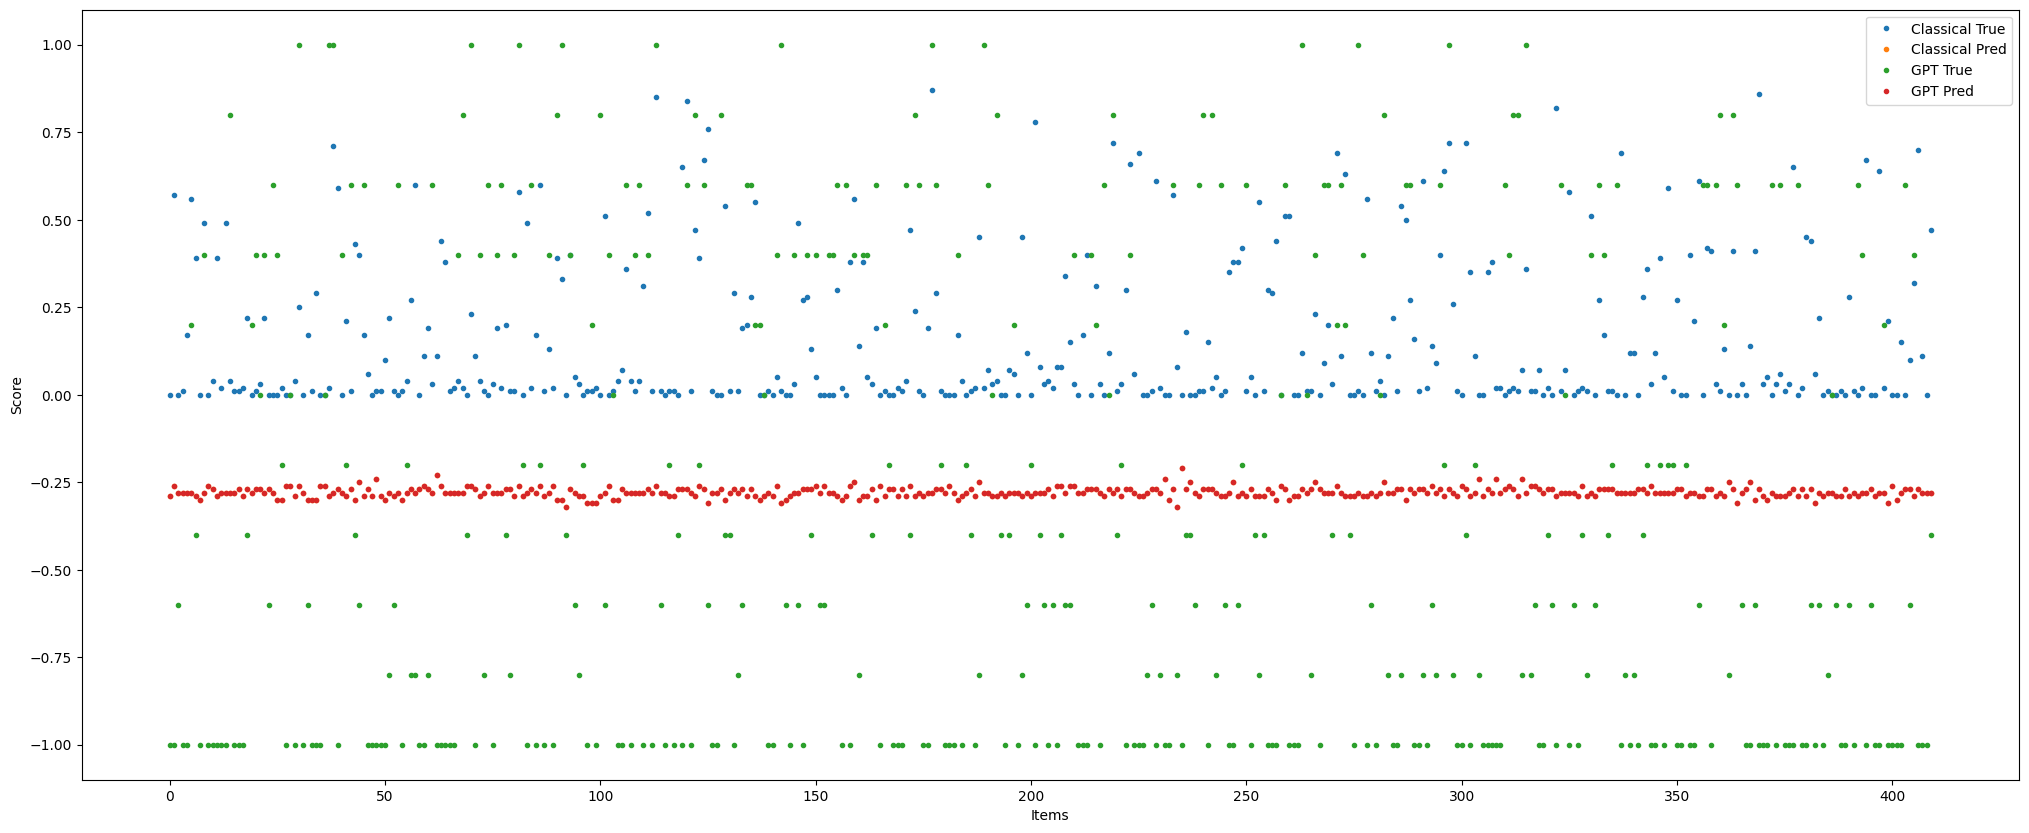

In [21]:
#
# Metrics visualization - True vs Pred
#

import matplotlib.pyplot as plt
df_true_pred.plot(style='.', figsize=(25,10))
plt.xlabel("Items")
plt.ylabel("Score")
plt.show()